In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
import netCDF4
import numpy
import os
import pandas
from PIL import Image
import random
import readline
import scipy
from scipy import fft
from scipy import linalg
from scipy import stats
from scipy.stats import poisson, ttest_ind
import seaborn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg
import xarray as xr

In [3]:
Diri = '/glade/u/home/whimkao//ExtraTrack/Output_Files/'

In [4]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [5]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_Output_V4.csv')
    ET_DF = Open_File(Diri+Model+'_ET_Output_V4.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V4.csv')
    Storms_DF = Open_File(Diri+Model+'_Storms_Output_V4.csv')
    Time = []
    Start_Time = []
    End_Time = []
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Start_Time.append(Datetime(ET_DF["Start Time"][j]))
        End_Time.append(Datetime(ET_DF["End Time"][j]))
    Start_Time_All = []
    End_Time_All = []
    for k in range(len(Storms_DF)):
        Start_Time_All.append(Datetime(Storms_DF["Start Time"][k]))
        if type(Storms_DF["End Time"][k]) == str:
            End_Time_All.append(Datetime(Storms_DF["End Time"][k]))
        else:
            End_Time_All.append(numpy.nan)
    Data_DF["Time(Z)"] = Time
    ET_DF["Start Time"] = Start_Time
    ET_DF["End Time"] = End_Time
    Storms_DF["Start Time"] = Start_Time_All
    Storms_DF["End Time"] = End_Time_All
    return (Data_DF, ET_DF, Codes_DF, Storms_DF)

In [6]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [7]:
Control_Data, Control_ET, Control_Codes, Control_Storms = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes, RCP45_Storms = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes, RCP85_Storms = Files_Open("RCP85", Diri)

In [8]:
#Control_Data[265:277]

In [9]:
#Control_ET[5:8]

In [10]:
#Control_Codes[5:8]

In [11]:
Control_Storms[8:13]

,Code,Name,Storm Type,Path Type,Start Time,End Time
8,TC190104,Kinen,ET Transition Incomplete,0,1901-09-11 00:00:00,NaT
9,TC190105,Lydia,ET Transition Complete,1,1901-09-27 12:00:00,1901-09-29 18:00:00
10,TC190106,Mario,ET Transition Complete,1,1901-09-22 00:00:00,1901-09-22 18:00:00
11,TC190107,Nicole,ET Transition Complete,2,1901-10-14 12:00:00,1901-10-15 00:00:00
12,TC190108,Phil,No ET Transition,0,1901-10-14 18:00:00,NaT


In [12]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)
VLT_Bins = Create_Bins(-600,600,50)
B_Bins = Create_Bins(-45,135,7.5)
Bins_Bounds = numpy.array([-600,600,50,-45,135,7.5])

In [13]:
Num_Years = numpy.array([90,93,93])

In [14]:
# Find Percentage of Storms That Complete ET Transition
def Storm_Types(Storms_DF, Years):
# ET Transition Completion
    Storm_Type_Count = numpy.zeros(3)
    Total_Len = len(Storms_DF)
    for i in range(Total_Len):
        if Storms_DF["Storm Type"][i] == "No ET Transition":
            Storm_Type_Count[0] += 1
        elif Storms_DF["Storm Type"][i] == "ET Transition Incomplete":
            Storm_Type_Count[1] += 1
        elif Storms_DF["Storm Type"][i] == "ET Transition Complete":
            Storm_Type_Count[2] += 1
    Storm_Type_Percent = Storm_Type_Count / Total_Len
    Storm_Type_Annual = Storm_Type_Count / Years
#
# ET Transition Type
    Storms_DF_ET = Storms_DF[Storms_DF["Path Type"] > 0].reset_index()
    Path_Type_Count = numpy.zeros(3)
    ET_Len = len(Storms_DF_ET)
    for j in range(ET_Len):
        if Storms_DF_ET["Path Type"][j] == 1:
            Path_Type_Count[0] += 1
        elif Storms_DF_ET["Path Type"][j] == 2:
            Path_Type_Count[1] += 1
        elif Storms_DF_ET["Path Type"][j] == 3:
            Path_Type_Count[2] += 1
    Path_Type_Percent = Path_Type_Count / ET_Len
    Path_Type_Annual = Path_Type_Count / Years
    return (Storm_Type_Percent, Storm_Type_Annual, Path_Type_Percent, Path_Type_Annual)
Storm_Types_List = ["No ET Transition", "Incomplete ET Transition", "Complete ET Transition"]
Path_Types_List = ["Type 1", "Type 2", "Type 3"]

In [15]:
# Create Bar Graph
def Bar_Graph(Fig, Array, Type, Var, Types_List, Months):
    if Type == "Relative":
        Axis = Fig.add_subplot(1,2,1)
    else:
        Axis = Fig.add_subplot(1,2,2)
#
# Create Bars
    Bar_Width = 0.25
    Bar1 = numpy.arange(3)
    Bar2 = [x + Bar_Width for x in Bar1]
    Bar3 = [x + Bar_Width for x in Bar2]
    Bars = [Bar1, Bar2, Bar3]
    Colours = ['limegreen', 'orange', 'red']
    Models = ['Control', 'RCP4.5', 'RCP8.5']
#
# Plot Bar Graph
    for l in range(3):
        Axis.bar(Bars[l], Array[l], width=Bar_Width, color=Colours[l], edgecolor='grey', label=Models[l])
# Formatting
    if Var == "ET Transition Completion":
        pyplot.xticks([n+0.5-Bar_Width for n in range(len(Types_List))], Types_List)
        pyplot.xlabel('ET Transition Completion Status', fontsize=15)
    elif Var == "ET Transition Path Type":
        pyplot.xticks([n+0.5-Bar_Width for n in range(len(Types_List))], Types_List)
        pyplot.xlabel('ET Transition Path Type', fontsize=15)
    if Type == "Relative":
        pyplot.ylabel('Percentage of Storms', fontsize=15)
        pyplot.yticks(Create_Bins(0,1,0.05))
        pyplot.ylim(0,0.6)
        pyplot.legend(loc=1, fontsize=12)
    else:
        Max_Val = numpy.max(Array)
        Max = (int(Max_Val / 0.5) + 1) * 0.5
        pyplot.ylabel('Annual Frequency', fontsize=15)
        pyplot.yticks(Create_Bins(0,Max,0.5))
        pyplot.ylim(0,Max)
    if len(str(Months)) > 0:
        Title = str(Var + ' For ' + Months)
    else:
        if Var == "ET Transition Completion" and Type == "Relative":
            Title = 'Probability of ET Transition Completion Status'
        elif Var == "ET Transition Completion" and Type == "Absolute":
            Title = 'Frequency of ET Transition Completion Status'
        else:
            Title = Var
    pyplot.title(Title, fontsize=18)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [16]:
# Create Function to Plot Histograms
def ET_Histograms(Control_Storms, Control_ET, RCP45_Storms, RCP45_ET, RCP85_Storms, RCP85_ET, Var, Months, Savefig):
    Control_Storm_Percent, Control_Storm_Annual, Control_Path_Percent, Control_Path_Annual = \
    Storm_Types(Control_Storms, Num_Years[0])
    RCP45_Storm_Percent, RCP45_Storm_Annual, RCP45_Path_Percent, RCP45_Path_Annual = \
    Storm_Types(RCP45_Storms, Num_Years[1])
    RCP85_Storm_Percent, RCP85_Storm_Annual, RCP85_Path_Percent, RCP85_Path_Annual = \
    Storm_Types(RCP85_Storms, Num_Years[2])
#
# Plot
    Fig = pyplot.figure(figsize=(13,6))
    if Var == "ET Transition Completion":
        Bar_Graph(Fig, [Control_Storm_Percent, RCP45_Storm_Percent, RCP85_Storm_Percent], \
        "Relative", Var, Storm_Types_List, Months)
        Bar_Graph(Fig, [Control_Storm_Annual, RCP45_Storm_Annual, RCP85_Storm_Annual], \
        "Absolute", Var, Storm_Types_List, Months)
    else:
        Bar_Graph(Fig, [Control_Path_Percent, RCP45_Path_Percent, RCP85_Path_Percent], \
        "Relative", Var, Path_Types_List, Months)
        Bar_Graph(Fig, [Control_Path_Annual, RCP45_Path_Annual, RCP85_Path_Annual], \
        "Absolute", Var, Path_Types_List, Months)
    pyplot.tight_layout()
    Figname = str('ET_Transition_Completion.png')
    if Savefig == True:
        Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V4/'+Figname, bbox_inches='tight')

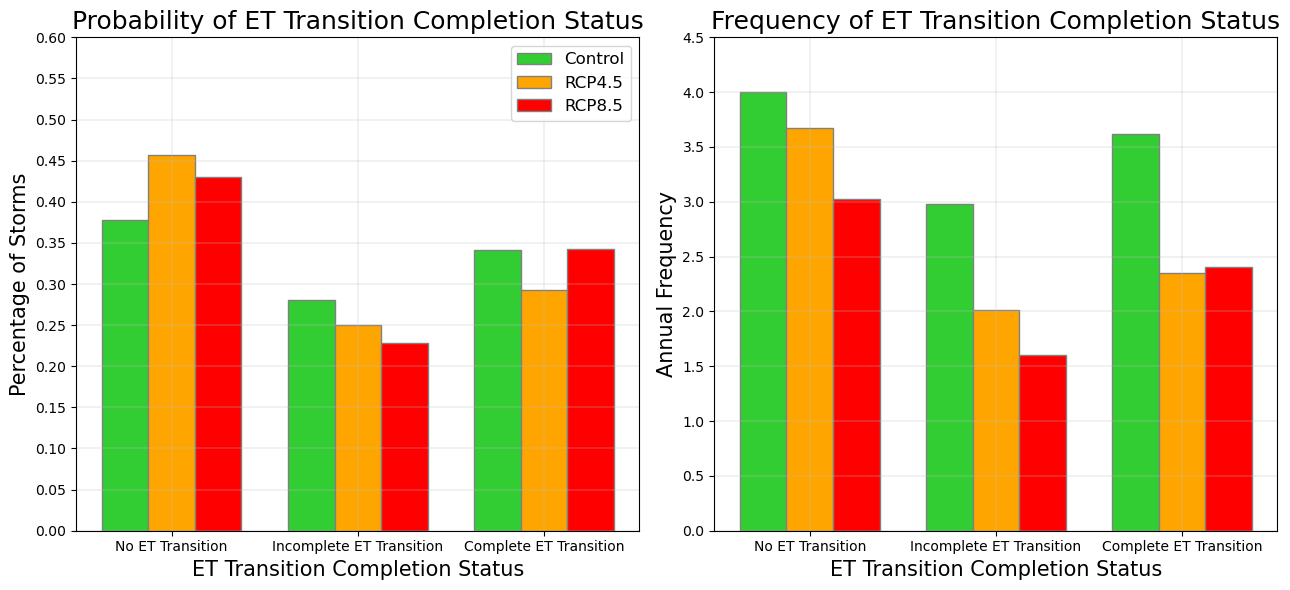

In [17]:
# Plot Histograms
ET_Histograms(Control_Storms, Control_ET, RCP45_Storms, RCP45_ET, RCP85_Storms, RCP85_ET, \
"ET Transition Completion", "", True)

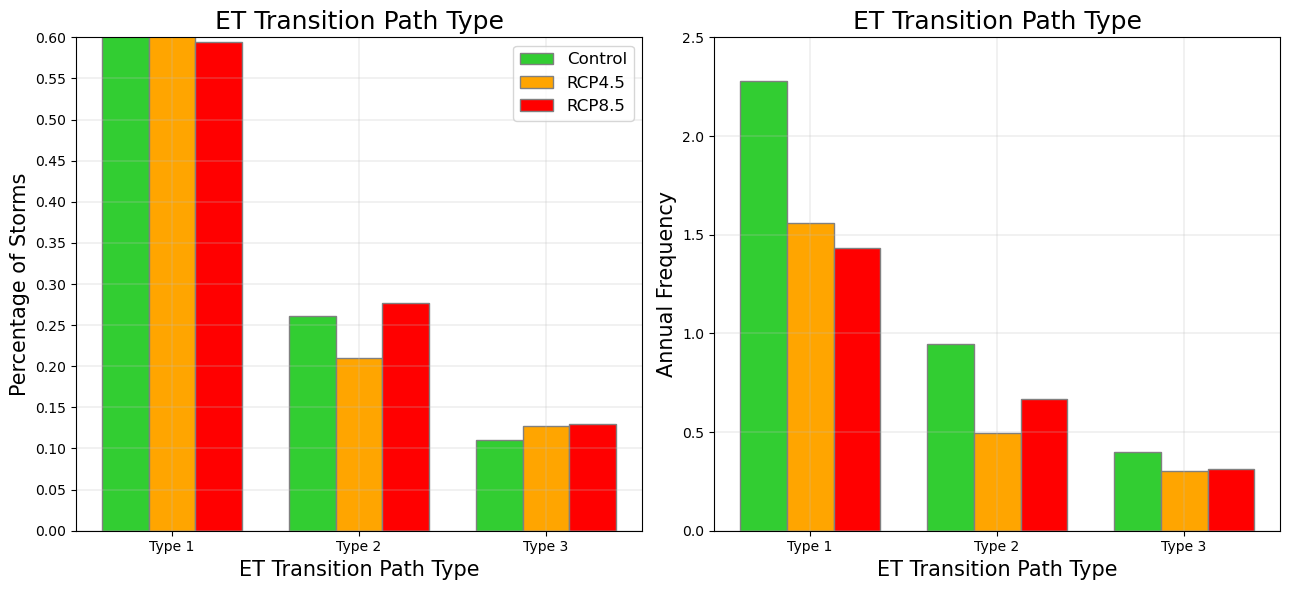

In [18]:
ET_Histograms(Control_Storms, Control_ET, RCP45_Storms, RCP45_ET, RCP85_Storms, RCP85_ET, \
"ET Transition Path Type", "", False)

In [19]:
# Find The Month of Each Storm
def Months_Find(Storm_DF):
    Month = []
    for j in range(len(Storm_DF)):
        Month.append(Storm_DF["Start Time"][j].month)
    Storm_DF["Start Month"] = Month
    return (Storm_DF)
Control_Storm_Months = Months_Find(Control_Storms)
RCP45_Storm_Months = Months_Find(RCP45_Storms)
RCP85_Storm_Months = Months_Find(RCP85_Storms)

In [20]:
# Storms in Each Month Range
def Months_Storms(Storm_DF, ET_DF, Start, End):
    if Start <= End:
        Months_Data = Storm_DF[(Storm_DF["Start Month"] >= Start) & (Storm_DF["Start Month"] <= End)]\
        .reset_index()
    else:
        Months_Data = Storm_DF[(Storm_DF["Start Month"] >= Start) | (Storm_DF["Start Month"] <= End)]\
        .reset_index()
    Months_ET = ET_DF[ET_DF["Code"].isin(list(Months_Data["Code"]))].reset_index()
    Months_Storm = Storm_DF[Storm_DF["Code"].isin(list(Months_Data["Code"]))].reset_index()
    Months_ET = Months_ET.drop("index", axis=1)
    Months_Storm = Months_Storm.drop("index", axis=1)
    return (Months_ET, Months_Storm)

In [20]:
#Control_ET_Jan_Jun, Control_Storm_Jan_Jun = \
#Months_Storms(Control_Storm_Months, Control_ET, 1, 6)
#RCP45_ET_Jan_Jun, RCP45_Storm_Jan_Jun = \
#Months_Storms(RCP45_Storm_Months, RCP45_ET, 1, 6)
#RCP85_ET_Jan_Jun, RCP85_Storm_Jan_Jun = \
#Months_Storms(RCP85_Storm_Months, RCP85_ET, 1, 6)
#ET_Histograms(Control_Storm_Jan_Jun, Control_ET_Jan_Jun, RCP45_Storm_Jan_Jun, RCP45_ET_Jan_Jun, \
#RCP85_Storm_Jan_Jun, RCP85_ET_Jan_Jun, "ET Transition Completion", "Jan - Jun", False)
#ET_Histograms(Control_Storm_Jan_Jun, Control_ET_Jan_Jun, RCP45_Storm_Jan_Jun, RCP45_ET_Jan_Jun, \
#RCP85_Storm_Jan_Jun, RCP85_ET_Jan_Jun, "ET Transition Path Type", "Jan - Jun", False)
#Control_ET_Jul, Control_Storm_Jul = \
#Months_Storms(Control_Storm_Months, Control_ET, 7, 7)
#RCP45_ET_Jul, RCP45_Storm_Jul = \
#Months_Storms(RCP45_Storm_Months, RCP45_ET, 7, 7)
#RCP85_ET_Jul, RCP85_Storm_Jul = \
#Months_Storms(RCP85_Storm_Months, RCP85_ET, 7, 7)
#ET_Histograms(Control_Storm_Jul, Control_ET_Jul, RCP45_Storm_Jul, RCP45_ET_Jul, \
#RCP85_Storm_Jul, RCP85_ET_Jul, "ET Transition Completion", "July", False)

In [21]:
# Create Line Graph
def Months_ET_Graph(Control_Storm_Months, RCP45_Storm_Months, RCP85_Storm_Months, 
Control_ET, RCP45_ET, RCP85_ET, Var, Savefig):
# Find Probability and Monthly Frequency
    Prob = numpy.zeros((3,12))
    Monthly = numpy.zeros((3,12))
    for j in range(3):
        if j == 0:
            Storm_Months = Control_Storm_Months
            ET_DF = Control_ET
        elif j == 1:
            Storm_Months = RCP45_Storm_Months
            ET_DF = RCP45_ET
        elif j == 2:
            Storm_Months = RCP85_Storm_Months
            ET_DF = RCP85_ET
        for k in range(12):
            ET_DF_Month, Storm_DF_Month = \
            Months_Storms(Storm_Months, ET_DF, int(k+1), int(k+1))
            Storm_Percent, Storm_Annual, NAN, NAN = Storm_Types(Storm_DF_Month, Num_Years[j])
            Prob[j][k] = Storm_Percent[Var]
            Monthly[j][k] = Storm_Annual[Var]
#
# Plot Relative
    Months_Number = Create_Bins(1,12,1)
    Fig = pyplot.figure(figsize=(12,10))
    Axis = Fig.add_subplot(2,1,1)
    Axis.plot(Months_Number, Prob[0], color='limegreen', linewidth=3.8, label='Control')
    Axis.plot(Months_Number, Prob[1], color='orange', linewidth=3.8, label='RCP45')
    Axis.plot(Months_Number, Prob[2], color='red', linewidth=3.8, label='RCP85')
    Months_ET_Formatting(Axis, Prob, Var, True)
#
# Plot Monthly
    Axis = Fig.add_subplot(2,1,2)
    Axis.plot(Months_Number, Monthly[0], color='limegreen', linewidth=3.8, label='Control')
    Axis.plot(Months_Number, Monthly[1], color='orange', linewidth=3.8, label='RCP45')
    Axis.plot(Months_Number, Monthly[2], color='red', linewidth=3.8, label='RCP85')
    Months_ET_Formatting(Axis, Monthly, Var, False)
# Formatting
    pyplot.legend(loc=2, fontsize=15)
    pyplot.tight_layout()
    if Var == 0:
        Figname = str('Month_No_ET_Prob.png')
    elif Var == 1:
        Figname = str('Month_ET_Incomplete_Prob.png')
    elif Var == 2:
        Figname = str('Month_ET_Complete_Prob.png')
    if Savefig == True:
        Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V4/'+Figname, bbox_inches='tight')

In [22]:
def Months_ET_Formatting(Axis, Data, Var, Relative):
    Months_Number = Create_Bins(1,12,1)
    Months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    if Var == 0:
        Label = "No ET Transition"
    elif Var == 1:
        Label = "Incomplete ET Transition"
    if Var == 2:
        Label = "Complete ET Transition"
    pyplot.xticks(Months_Number, Months)
    pyplot.xlim(0.95,12.05)
    pyplot.xlabel("Month", fontsize=18)
    if Relative == True:
        Max = (int(numpy.max(Data)/0.1+1.2)) * 0.1
        pyplot.yticks(Create_Bins(0,Max,0.1))
        pyplot.ylim(0,Max)
        pyplot.ylabel("Probability", fontsize=18)
        pyplot.title("Probability of " + Label + " For Each Month", fontsize=24)
    else:
        Max = (int(numpy.max(Data)/0.2+1.2)) * 0.2
        pyplot.yticks(Create_Bins(0,Max,0.2))
        pyplot.ylim(0,Max)
        pyplot.ylabel("Monthly Frequency", fontsize=18)
        pyplot.title("Frequency of " + Label + " For Each Month", fontsize=24)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    return (Axis)

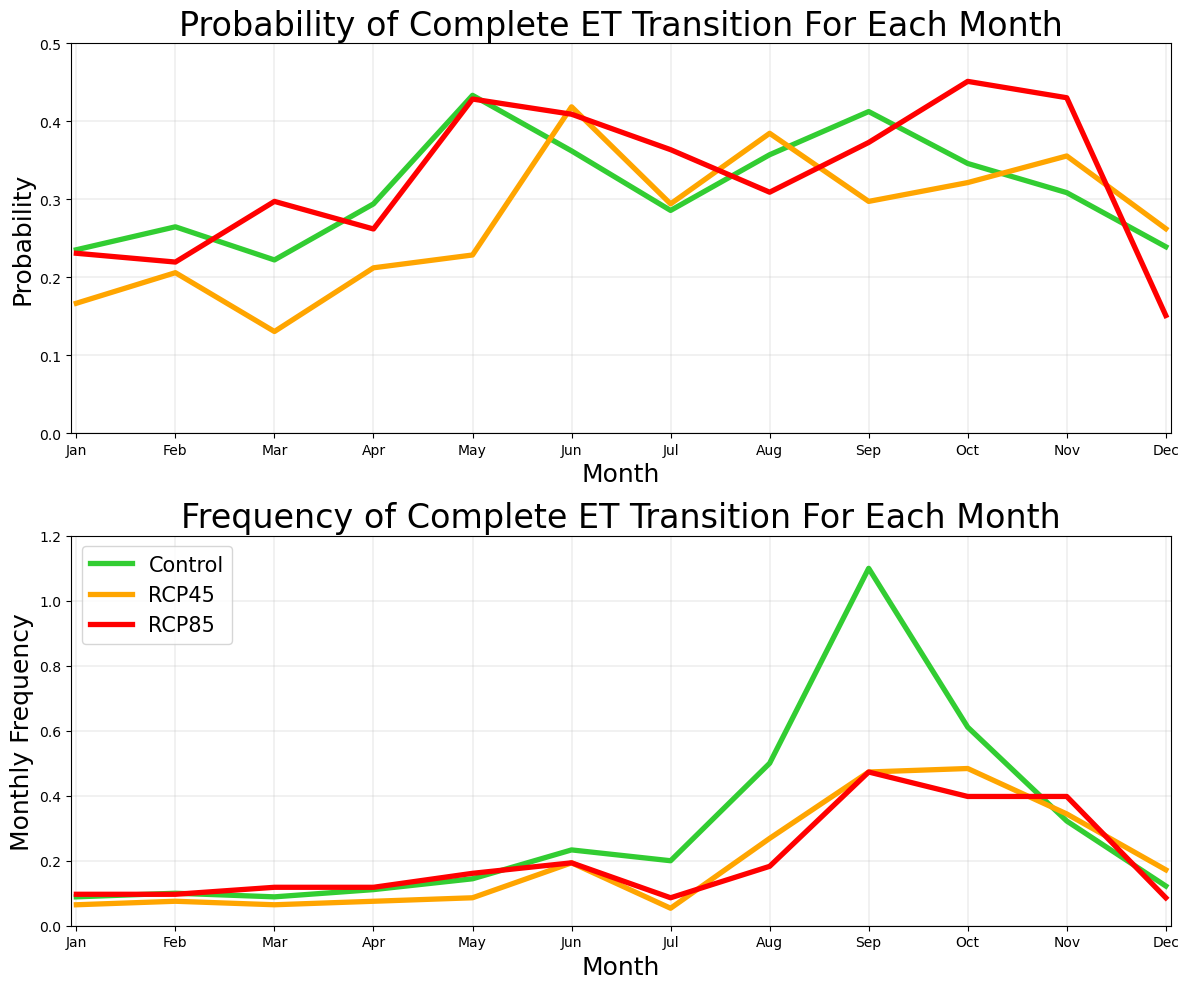

In [23]:
# Apply Function For Complete ET Transition
Months_ET_Graph(Control_Storm_Months, RCP45_Storm_Months, RCP85_Storm_Months, 
Control_ET, RCP45_ET, RCP85_ET, 2, True)

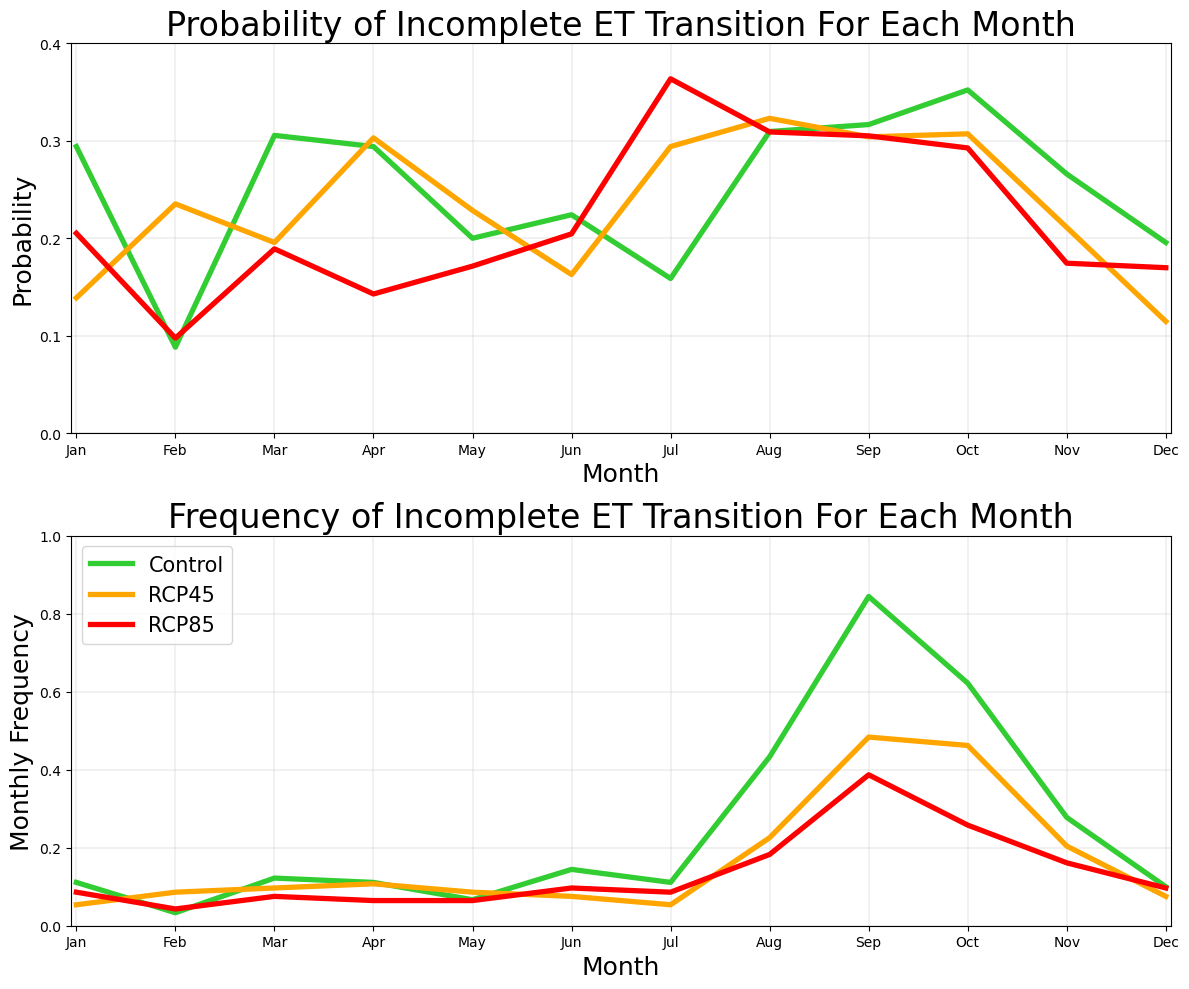

In [24]:
# Apply Function For Incomplete ET Transition
Months_ET_Graph(Control_Storm_Months, RCP45_Storm_Months, RCP85_Storm_Months, 
Control_ET, RCP45_ET, RCP85_ET, 1, True)

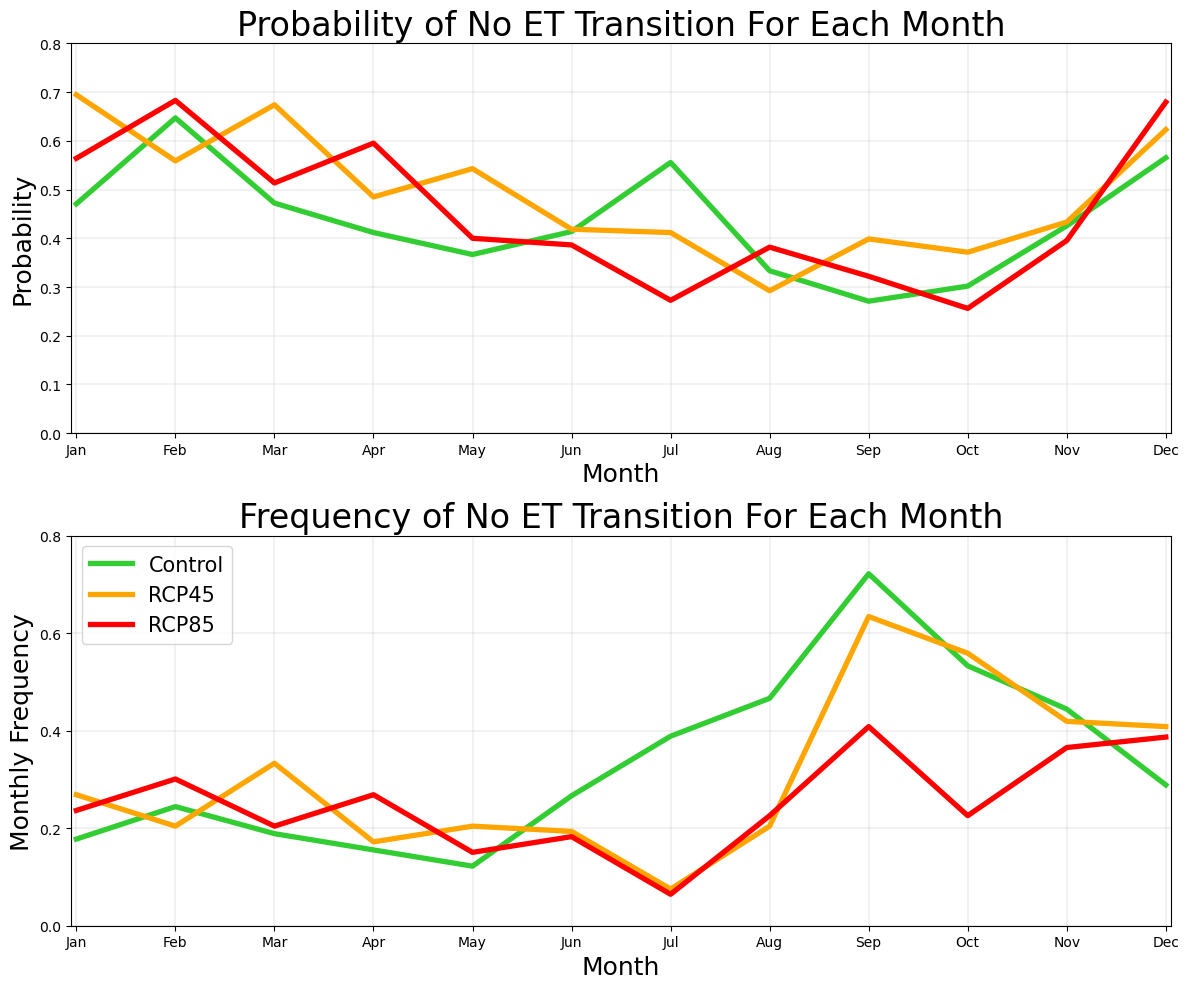

In [25]:
# Apply Function For No ET Transition
Months_ET_Graph(Control_Storm_Months, RCP45_Storm_Months, RCP85_Storm_Months, 
Control_ET, RCP45_ET, RCP85_ET, 0, True)

In [26]:
Month_Days = numpy.zeros(13)
for m in range(13):
    if m < 12:
        Days = datetime.date(2023,m+1,1) - datetime.date(2023,1,1)
        Month_Days[m] = int(Days.days)
    else:
        Month_Days[m] = 365
Months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan"]
Day_Vals = Create_Bins(0,365,5)

In [27]:
# Function For Calculating How Many Days Since January 1st
def Date_Days(Storms_DF):
    Storms_Days = Storms_DF.copy()
    Start_Time = Storms_Days["Start Time"]
    Days_Array = numpy.zeros(len(Start_Time))
    for i in range(len(Start_Time)):
        Time = Start_Time[i].date()
        Year = Time.year
        NYD = datetime.date(Year,1,1)
        Days = Time - NYD
        Days_Array[i] = Days.days
    Storms_Days["Days"] = Days_Array
    return (Storms_Days)
Control_Storms_Days = Date_Days(Control_Storms)
RCP45_Storms_Days = Date_Days(RCP45_Storms)
RCP85_Storms_Days = Date_Days(RCP85_Storms)

In [28]:
# Function For Creating the Cumulative Distribution
def Cum_Dist_Date(Array):
    Len = len(Array)
# Sort Number of Days Since January 1st
    Sorted_0 = numpy.sort(Array)
#
# Apply Smoothing
    Sorted_Final = Smoothing_Cum(Sorted_0, 5)
    Density = numpy.arange(0,1.0001,1/(Len-1))
    return (Sorted_Final, Density)

In [29]:
# Function For Cumulative Distribution Smoothing
def Smoothing_Cum(Sorted, Len):
    Len = len(Sorted)
    F = Len-1
    for i in range(Len):
        if i > 0 and i < F:
# Smoothing Based on Data Points i+3 and i-3
            Orig_Val = Sorted[i]
            if i == 1:
                Outside_Diff = Sorted[i+3] + (Sorted[F] - Sorted[F-2])
            elif i == 2:
                Outside_Diff = Sorted[i+3] + (Sorted[F] - Sorted[F-1])
            elif i == F-2:
                Outside_Diff = Sorted[1] + (Sorted[F] - Sorted[i-3])
            elif i == F-1:
                Outside_Diff = Sorted[2] + (Sorted[F] - Sorted[i-3])
            else:
                Outside_Diff = Sorted[i+3] - Sorted[i-3]
# Use 20% of the Original Value, 40% of Smoothing From i-1 and 40% of Smoothing From i+1
            Sorted[i] = (0.2 * Orig_Val) + (0.4 * (Sorted[i-1] + Outside_Diff / 6)) + \
            (0.4 * (Sorted[i+1] - Outside_Diff / 6))
    return (Sorted)

In [30]:
# Function for Creating the Probability Distribution
def Prob_Dist_New(DF):
    Cum_Sorted, Cum_Density = Cum_Dist_Date(DF["Days"])
    Len = len(Cum_Sorted)
    Start_Val = 0
    End_Val = 365
    Width = 5
    Param = 15
    Range = int((End_Val - Start_Val) / Width)
# Create Range of Days Values
    Day_Vals = Create_Bins(Start_Val, End_Val, Width)
    Prob_Count_0 = numpy.zeros(Range+1)
# Count Number of Values Between Data Points k+3 and k-3 (Range of 30 Days)
    for k in range(Range+1):
        if k <= 3 or k >= Range-2:
            if k == 0:
                Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Day_Vals[k] + 15)]
                Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= End_Val - 15)]
            elif k == 1:
                Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Day_Vals[k] + 20)]
                Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= End_Val - 10)]
            elif k == 2:
                Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Day_Vals[k] + 25)]
                Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= End_Val - 5)]
            elif k == Range-2:
                Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Start_Val + 5)]
                Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= Day_Vals[k] - 25)]
            elif k == Range-1:
                Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Start_Val + 10)]
                Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= Day_Vals[k] - 20)]
            elif k == Range:
                Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Start_Val + 15)]
                Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= Day_Vals[k] - 15)]
            Count = len(Vals_Range_1) + len(Vals_Range_2)
        else:
            Vals_Range = Cum_Sorted[(Cum_Sorted >= Day_Vals[k]-Param) & \
            (Cum_Sorted < Day_Vals[k]+Param)]
            Count = len(Vals_Range)
        Prob_Count_0[k] = Count / (2 * Param)
# Apply Smoothing Twice
    Prob_Count_1 = Smoothing_Prob(Prob_Count_0)
    Prob_Count_2 = Smoothing_Prob(Prob_Count_1)
# Calculate Density By Dividing by The Length
    Prob_Density = Prob_Count_2 / Len
    return (Day_Vals, Prob_Density)

In [31]:
# Function For Probability Distribution Smoothing
def Smoothing_Prob(Count):
    Count_Len = len(Count)
    F = Count_Len-1
# Smoothing Based on Data Points k+3 and k-3
    for k in range(Count_Len):
        if k > 0 and k < F:
            Orig_Val = Count[k]
            if k == 1:
                Outside_Diff = Count[k+3] + (Count[F] - Count[F-2])
            elif k == 2:
                Outside_Diff = Count[k+3] + (Count[F] - Count[F-1])
            elif k == F-2:
                Outside_Diff = Count[1] + (Count[F] - Count[k-3])
            elif k == F-1:
                Outside_Diff = Count[2] + (Count[F] - Count[k-3])
            else:
                Outside_Diff = Count[k+3] - Count[k-3]
# Use 50% of the Original Value, 25% of Smoothing From i-1 and 25% of Smoothing From i+1
            Count[k] = (0.5 * Orig_Val) + (0.25 * (Count[k-1] + Outside_Diff / 6)) + \
            (0.25 * (Count[k+1] - Outside_Diff / 6))
        elif k == F:
            Orig_Val = Count[k]
            Outside_Diff = Count[3] + (Count[F] - Count[F-3])
            Count[k] = (0.5 * Orig_Val) + (0.25 * (Count[F-1] + Outside_Diff / 6)) + \
            (0.25 * (Count[1] - Outside_Diff / 6))
# First and Last Value Both Represent January 1st, Must be Same
            Count[0] = Count[k]
    return (Count)

In [32]:
# Create Function to Plot Cumulative Distribution
def ET_Cum_Dist_Plot(Fig, ET_DF_1, ET_DF_2, ET_DF_3, Var):
    Axis = Fig.add_subplot(1,1,1)
#
# Apply Cumulative Distribution Function
    Sorted_1, Density_1 = Cum_Dist_Date(ET_DF_1[Var])
    Sorted_2, Density_2 = Cum_Dist_Date(ET_DF_2[Var])
    Sorted_3, Density_3 = Cum_Dist_Date(ET_DF_3[Var])
#
# Plotting
    Axis.plot(Sorted_1, Density_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
    Axis.plot(Sorted_2, Density_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
    Axis.plot(Sorted_3, Density_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
#
# Formatting
    pyplot.xticks(Month_Days, Months)
    pyplot.xlim(-1,366)
    pyplot.yticks(Create_Bins(0,1,0.125))
    pyplot.ylim(0,1)
    pyplot.xlabel("Month", fontsize=18)
    pyplot.ylabel("Cumulative Frequency Density", fontsize=18)
    pyplot.legend(loc=4, fontsize=15)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

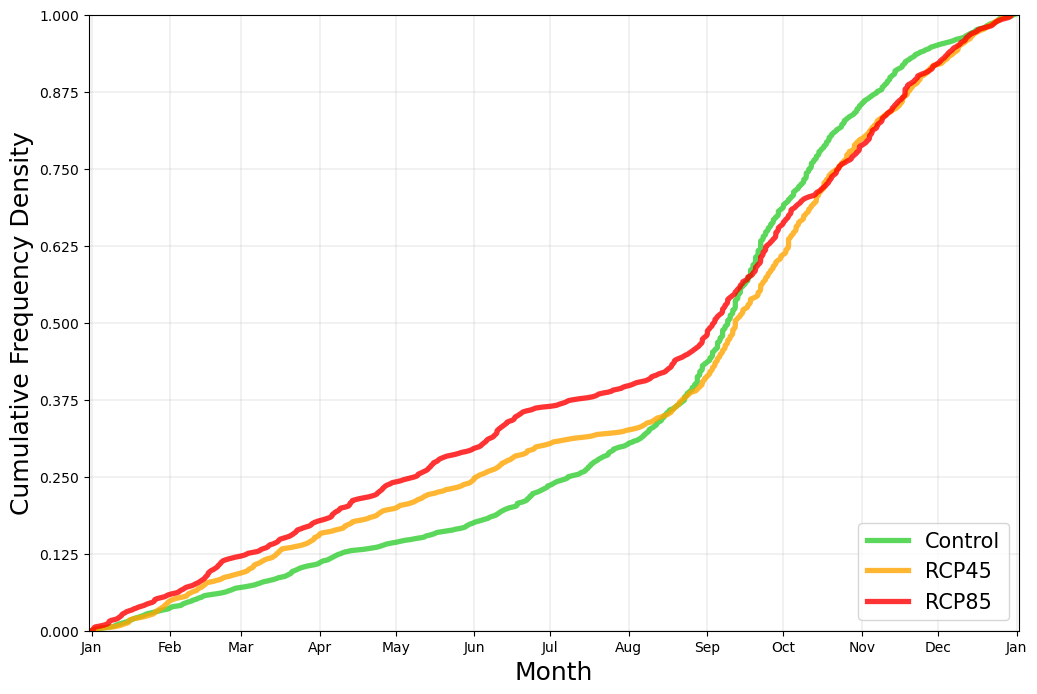

In [33]:
# Plot Cumulative Distribution
Fig = pyplot.figure(figsize=(12,8))
ET_Cum_Dist_Plot(Fig, Control_Storms_Days, RCP45_Storms_Days, RCP85_Storms_Days, "Days")

In [34]:
# Create Function to Plot Probability Distribution
def ET_Prob_Dist_Plot(Fig, ET_DF_1, ET_DF_2, ET_DF_3):
    Axis = Fig.add_subplot(1,1,1)
#
# Apply Probability Distribution Function
    Values_1, Density_1 = Prob_Dist_New(ET_DF_1)
    Values_2, Density_2 = Prob_Dist_New(ET_DF_2)
    Values_3, Density_3 = Prob_Dist_New(ET_DF_3)
#
# Plotting
    Axis.plot(Values_1, Density_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
    Axis.plot(Values_2, Density_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
    Axis.plot(Values_3, Density_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
#
# Formatting
    pyplot.xticks(Month_Days, Months)
    pyplot.xlim(-1,366)
    pyplot.yticks(Create_Bins(0,0.009,0.001))
    pyplot.ylim(0,0.009)
    pyplot.xlabel("Month", fontsize=18)
    pyplot.ylabel("Probability Frequency Density", fontsize=18)
    pyplot.legend(loc=2, fontsize=15)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

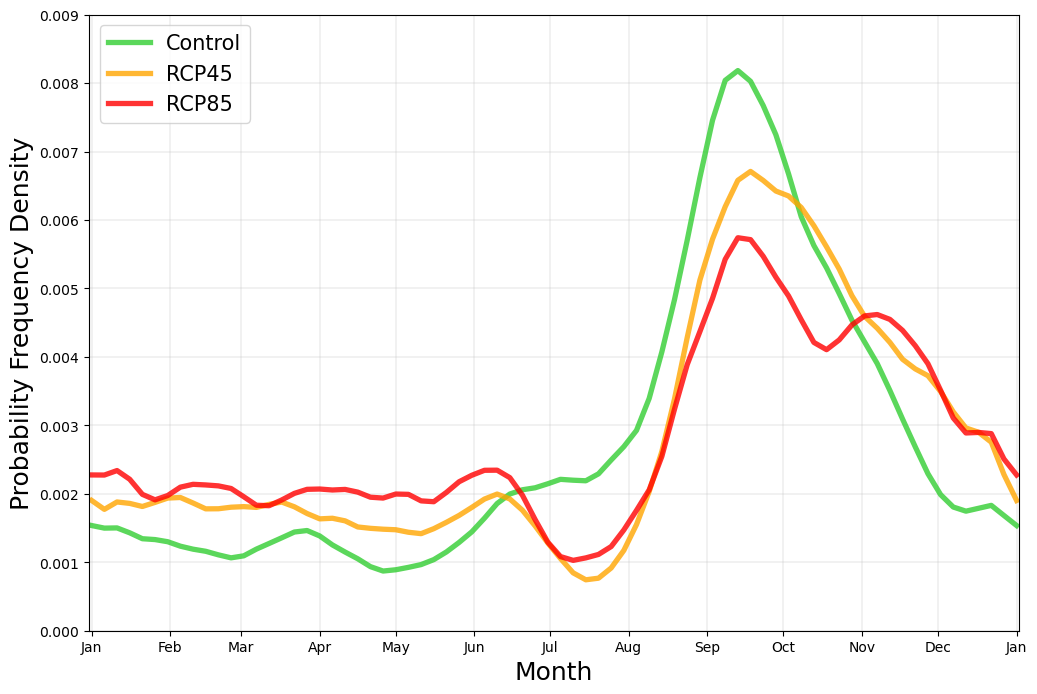

In [35]:
Fig = pyplot.figure(figsize=(12,8))
ET_Prob_Dist_Plot(Fig, Control_Storms_Days, RCP45_Storms_Days, RCP85_Storms_Days)

In [36]:
# Find Frequency of Storm Over the Entire 90 Year Period Using Prob Distribution Above
Values, Density_1 = Prob_Dist_New(Control_Storms_Days)
Values, Density_2 = Prob_Dist_New(RCP45_Storms_Days)
Values, Density_3 = Prob_Dist_New(RCP85_Storms_Days)
Storm_Frequency_Dist = numpy.zeros((3,len(Density_1)))
# Multiply Densities by Total Number of Storms
# Then Multiply by 90 Years, Then Divide by 3 Different ET Statuses
Storm_Frequency_Dist[0] = Density_1 * len(Control_Storms_Days) * Num_Years[0] / 3
Storm_Frequency_Dist[1] = Density_2 * len(RCP45_Storms_Days) * Num_Years[1] / 3
Storm_Frequency_Dist[2] = Density_3 * len(RCP85_Storms_Days) * Num_Years[2] / 3

In [37]:
# Count Actual Number of Storms In Each ET Status
def Actual_Count(DF):
    Start_Val = 0
    End_Val = 365
    Width = 5
    Param = 15
    Range = int((End_Val - Start_Val) / Width)
    Day_Vals = Create_Bins(Start_Val, End_Val, Width)
    ET_Status_Count = numpy.zeros((3,Range+1))
# Same Range of 30 Days As Above
    for k in range(Range+1):
        if k <= 3 or k >= Range-2:
# Create DataFrames Containing Data Within Each 30 Day Range
            if k == 0:
                DF_1 = DF[DF["Days"] < (Day_Vals[k] + 15)]
                DF_2 = DF[DF["Days"] >= (End_Val - 15)]
                Vals_DF = pandas.concat((DF_1, DF_2))
            elif k == 1:
                DF_1 = DF[DF["Days"] < (Day_Vals[k] + 20)]
                DF_2 = DF[DF["Days"] >= (End_Val - 10)]
                Vals_DF = pandas.concat((DF_1, DF_2))
            elif k == 2:
                DF_1 = DF[DF["Days"] < (Day_Vals[k] + 25)]
                DF_2 = DF[DF["Days"] >= (End_Val - 5)]
                Vals_DF = pandas.concat((DF_1, DF_2))
            elif k == Range-2:
                DF_1 = DF[DF["Days"] < (Start_Val + 5)]
                DF_2 = DF[DF["Days"] >= (Day_Vals[k] - 25)]
                Vals_DF = pandas.concat((DF_1, DF_2))
            elif k == Range-1:
                DF_1 = DF[DF["Days"] < (Start_Val + 10)]
                DF_2 = DF[DF["Days"] >= (Day_Vals[k] - 20)]
                Vals_DF = pandas.concat((DF_1, DF_2))
            elif k == Range:
                DF_1 = DF[DF["Days"] < (Start_Val + 15)]
                DF_2 = DF[DF["Days"] >= (Day_Vals[k] - 15)]
                Vals_DF = pandas.concat((DF_1, DF_2))
        else:
            Vals_DF = DF[(DF["Days"] >= (Day_Vals[k]-Param)) & \
            (DF["Days"] < (Day_Vals[k]+Param))]
#
# Separate Each DataFrame by Each ET Status, and Count Number of Each
        ET_Status_Count[0][k] = len(Vals_DF[Vals_DF["Storm Type"] == "No ET Transition"])
        ET_Status_Count[1][k] = len(Vals_DF[Vals_DF["Storm Type"] == "ET Transition Incomplete"])
        ET_Status_Count[2][k] = len(Vals_DF[Vals_DF["Storm Type"] == "ET Transition Complete"])
    return (ET_Status_Count)

In [38]:
# Apply Function For Each Model
Control_ET_Status_Count = Actual_Count(Control_Storms_Days)
RCP45_ET_Status_Count = Actual_Count(RCP45_Storms_Days)
RCP85_ET_Status_Count = Actual_Count(RCP85_Storms_Days)
#
# Sum Up Each ET Statuses to Find Count of Storms Over Entire 90 Year Period
Storm_Count_Actual = numpy.zeros((3,len(Control_ET_Status_Count[0])))
Storm_Count_Actual[0] = Control_ET_Status_Count[0] + Control_ET_Status_Count[1] + Control_ET_Status_Count[2]
Storm_Count_Actual[1] = RCP45_ET_Status_Count[0] + RCP45_ET_Status_Count[1] + RCP45_ET_Status_Count[2]
Storm_Count_Actual[2] = RCP85_ET_Status_Count[0] + RCP85_ET_Status_Count[1] + RCP85_ET_Status_Count[2]

In [39]:
# Plot Comparison Between Storm Frequency Distribution and Actual Storm Count
def ET_Prob_Dist_Count(Fig, Freqs, Counts, Values):
    Axis = Fig.add_subplot(1,1,1)
#
# Plotting
    Axis.plot(Values, Counts[0], color='darkgreen', linewidth=3.8, label='Control Count', alpha=0.8)
    Axis.plot(Values, Counts[1], color='orangered', linewidth=3.8, label='RCP45 Count', alpha=0.8)
    Axis.plot(Values, Counts[2], color='darkviolet', linewidth=3.8, label='RCP85 Count', alpha=0.8)
    Axis.plot(Values, Freqs[0], color='limegreen', linestyle='--', linewidth=3.8, label='Control Freq', alpha=0.8)
    Axis.plot(Values, Freqs[1], color='orange', linestyle='--', linewidth=3.8, label='RCP45 Freq', alpha=0.8)
    Axis.plot(Values, Freqs[2], color='red', linestyle='--', linewidth=3.8, label='RCP85 Freq', alpha=0.8)
##
# Formatting Based on Variable
    pyplot.xticks(Month_Days, Months)
    pyplot.xlim(-1,366)
    pyplot.yticks(Create_Bins(0,250,50))
    pyplot.ylim(0,250)
    pyplot.xlabel("Month", fontsize=18)
    pyplot.ylabel("Frequency", fontsize=18)
    pyplot.legend(loc=2, fontsize=12)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

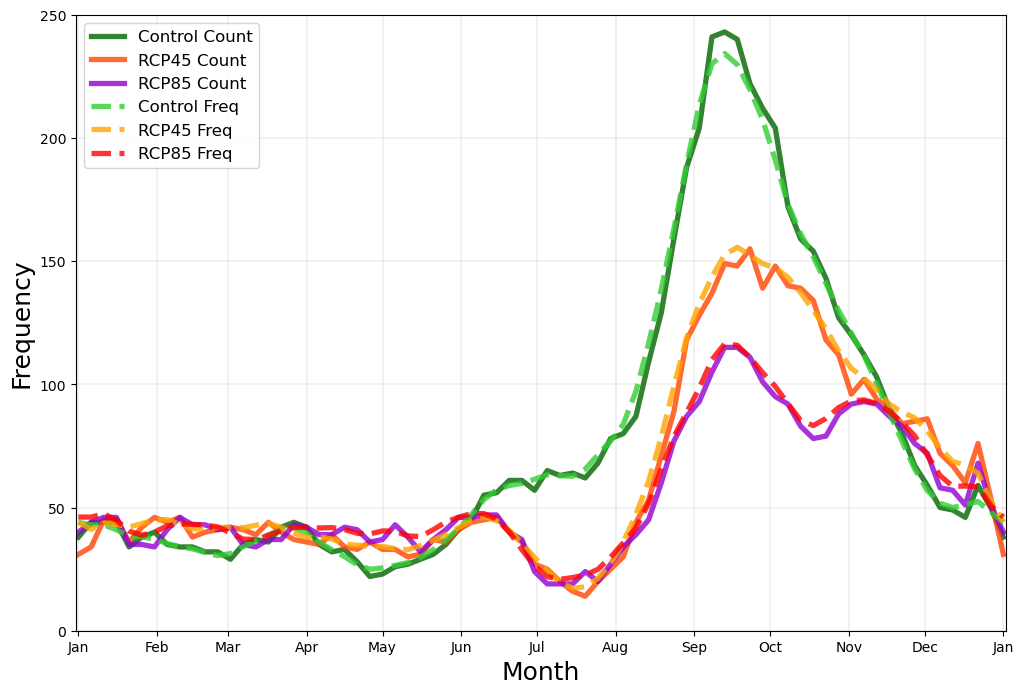

In [40]:
# Apply Function
Fig = pyplot.figure(figsize=(12,8))
ET_Prob_Dist_Count(Fig, Storm_Frequency_Dist, Storm_Count_Actual, Day_Vals)

In [41]:
def ET_Status_Formatting(Axis, Values, Freq):
    Axis.plot(Values, Freq[0], color='limegreen', linewidth=3.8, label='No ET Transition', alpha=0.8)
    Axis.plot(Values, Freq[1], color='darkcyan', linewidth=3.8, label='Incomplete ET Transition', alpha=0.8)
    Axis.plot(Values, Freq[2], color='mediumblue', linewidth=3.8, label='Complete ET Transition', alpha=0.8)
    pyplot.xticks(Month_Days, Months)
    pyplot.xlim(-1,366)
    pyplot.yticks(Create_Bins(0,250,20))
    pyplot.ylim(0,120)
    pyplot.xlabel("Month", fontsize=18)
    pyplot.ylabel("Frequency", fontsize=18)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [42]:
# Create Function to Plot ET Probability Distributions
def ET_Status_Freq_Plot(Fig, Control, RCP45, RCP85, Values):
    Axis = Fig.add_subplot(3,1,1)
    ET_Status_Formatting(Axis, Values, Control)
#
    Axis = Fig.add_subplot(3,1,2)
    ET_Status_Formatting(Axis, Values, RCP45)
    pyplot.legend(loc=2, fontsize=15)
#
    Axis = Fig.add_subplot(3,1,3)
    ET_Status_Formatting(Axis, Values, RCP85)

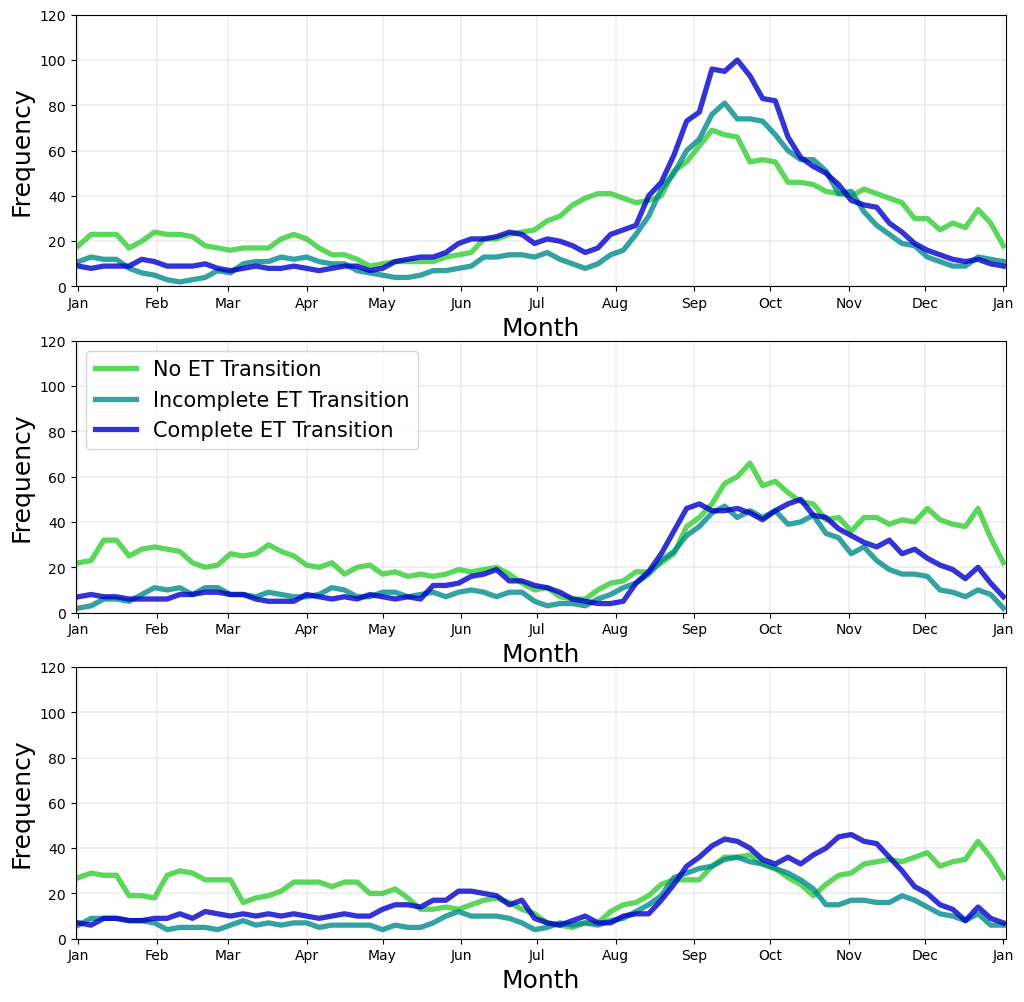

In [43]:
Fig = pyplot.figure(figsize=(12,12))
ET_Status_Freq_Plot(Fig, Control_ET_Status_Count, RCP45_ET_Status_Count, RCP85_ET_Status_Count, Day_Vals)

In [44]:
# Smoothen ET Status Count
def Status_Count_Smoothing(ET_Status_Count):
    Status_Count_Smoothen = numpy.zeros((3,len(ET_Status_Count[0])))
    for l in range(3):
        Status_Count_Smoothen[l] = Smoothing_Prob(ET_Status_Count[l])
    return (Status_Count_Smoothen)
Control_ET_Status_Smoothen = Status_Count_Smoothing(Control_ET_Status_Count)
RCP45_ET_Status_Smoothen = Status_Count_Smoothing(RCP45_ET_Status_Count)
RCP85_ET_Status_Smoothen = Status_Count_Smoothing(RCP85_ET_Status_Count)

In [45]:
# Find the Ratio Between Actual Count and Frequency Distribution
# Use this Ratio to Calculate Frequency of Each ET Status
def ET_Status_Count_Freq(ET_Status_Smoothen, Frequency_Dist):
    ET_Status_Freq = numpy.zeros((3,len(Frequency_Dist)))
    Storm_Count_New = ET_Status_Smoothen[0] + ET_Status_Smoothen[1] + ET_Status_Smoothen[2]
    for l in range(3):
        ET_Status_Freq[l] = ET_Status_Smoothen[l] / Storm_Count_New * Frequency_Dist
    return (ET_Status_Freq)
Control_ET_Status_Freq = ET_Status_Count_Freq(Control_ET_Status_Smoothen, Storm_Frequency_Dist[0])
RCP45_ET_Status_Freq = ET_Status_Count_Freq(RCP45_ET_Status_Smoothen, Storm_Frequency_Dist[1])
RCP85_ET_Status_Freq = ET_Status_Count_Freq(RCP85_ET_Status_Smoothen, Storm_Frequency_Dist[2])

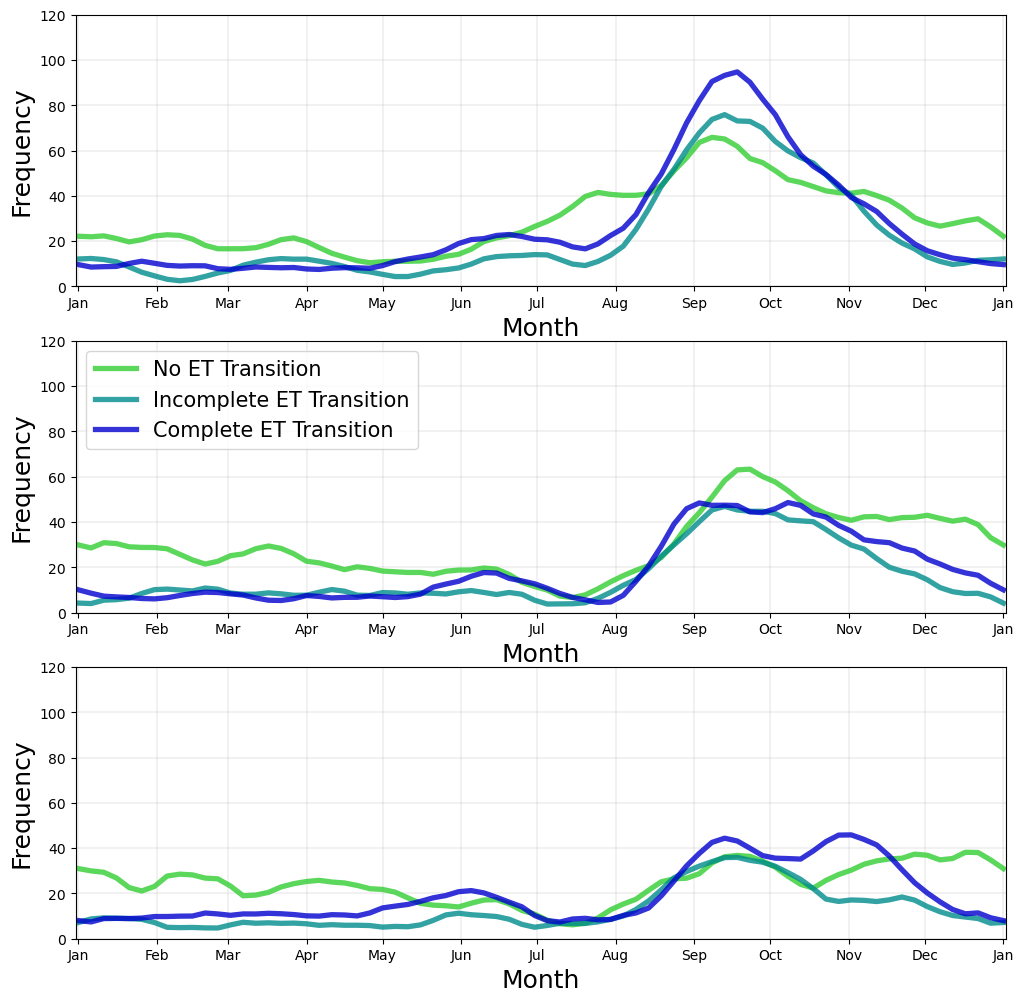

In [46]:
Fig = pyplot.figure(figsize=(12,12))
ET_Status_Freq_Plot(Fig, Control_ET_Status_Freq, RCP45_ET_Status_Freq, RCP85_ET_Status_Freq, Day_Vals)

In [47]:
# Calculate Percentage of Each ET Status
def ET_Status_Percentage(ET_Status_Freq):
    ET_Status_Percent = numpy.zeros((3,len(ET_Status_Freq[0])))
    Total_Freq = ET_Status_Freq[0] + ET_Status_Freq[1] + ET_Status_Freq[2]
    for l in range(3):
        ET_Status_Percent[l] = ET_Status_Freq[l] / Total_Freq
    return (ET_Status_Percent)
Control_ET_Status_Percent = ET_Status_Percentage(Control_ET_Status_Freq)
RCP45_ET_Status_Percent = ET_Status_Percentage(RCP45_ET_Status_Freq)
RCP85_ET_Status_Percent = ET_Status_Percentage(RCP85_ET_Status_Freq)

In [48]:
def ET_Status_Percent_Formatting(Axis, Values, Percent):
    No_ET_Percent = Percent[0]
    Complete_ET_Reverse = 1 - Percent[2]
    Axis.plot(Values, No_ET_Percent, color='limegreen', linewidth=3.8, \
    label='No ET / Incomplete ET Transition', alpha=0.8)
    Axis.plot(Values, Complete_ET_Reverse, color='mediumblue', linewidth=3.8, \
    label='Incomplete ET / Complete ET Transition', alpha=0.8)
    pyplot.xticks(Month_Days, Months)
    pyplot.xlim(-1,366)
    pyplot.yticks(Create_Bins(0,1,0.1))
    pyplot.ylim(0,1)
    pyplot.xlabel("Month", fontsize=18)
    pyplot.ylabel("Percentage", fontsize=18)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [49]:
# Create Function to Plot ET Probability Distributions
def ET_Status_Percent_Plot(Fig, Control, RCP45, RCP85, Values):
    Axis = Fig.add_subplot(3,1,1)
    ET_Status_Percent_Formatting(Axis, Values, Control)
#
    Axis = Fig.add_subplot(3,1,2)
    ET_Status_Percent_Formatting(Axis, Values, RCP45)
    pyplot.legend(loc=1, fontsize=15)
#
    Axis = Fig.add_subplot(3,1,3)
    ET_Status_Percent_Formatting(Axis, Values, RCP85)

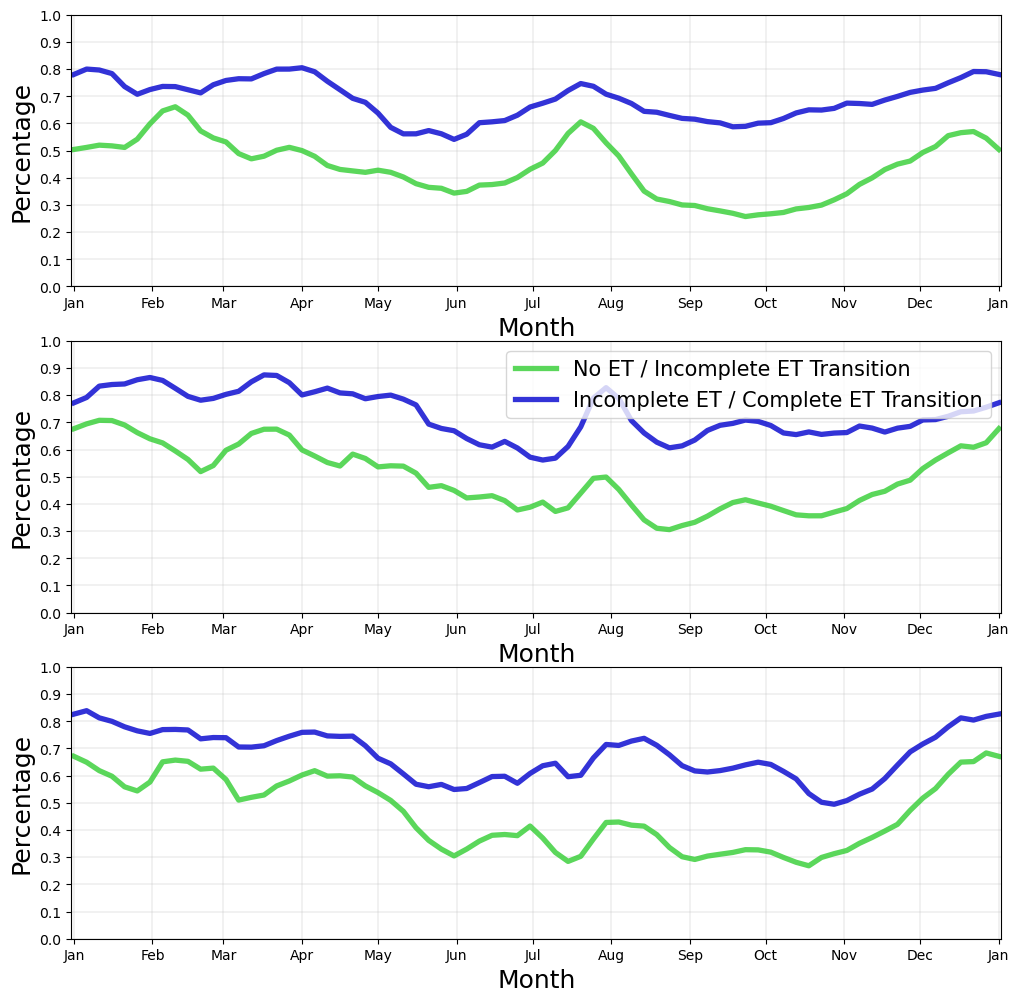

In [50]:
Fig = pyplot.figure(figsize=(12,12))
ET_Status_Percent_Plot(Fig, Control_ET_Status_Percent, RCP45_ET_Status_Percent, \
RCP85_ET_Status_Percent, Day_Vals)

In [51]:
# Function For Percentage Smoothing
def Smoothing_Percent(Percent_1, Percent_2):
    Len = len(Percent_1)
    F = Len-1
# Smoothing Based on Data Points k+3 and k-3, and Difference Between the Two Percentages
    for k in range(Len):
        if k > 0 and k < F:
            Orig_Val_1 = Percent_1[k]
            Orig_Val_2 = Percent_2[k]
            if k == 1:
                Outside_Diff_1 = Percent_1[k+3] + (Percent_1[F] - Percent_1[F-2])
                Outside_Diff_2 = Percent_2[k+3] + (Percent_2[F] - Percent_2[F-2])
            if k == 2:
                Outside_Diff_1 = Percent_1[k+3] + (Percent_1[F] - Percent_1[F-1])
                Outside_Diff_2 = Percent_2[k+3] + (Percent_2[F] - Percent_2[F-1])
            elif k == F-2:
                Outside_Diff_1 = Percent_1[1] + (Percent_1[F] - Percent_1[k-3])
                Outside_Diff_2 = Percent_2[1] + (Percent_2[F] - Percent_2[k-3])
            elif k == F-1:
                Outside_Diff_1 = Percent_1[2] + (Percent_1[F] - Percent_1[k-3])
                Outside_Diff_2 = Percent_2[2] + (Percent_2[F] - Percent_2[k-3])
            else:
                Outside_Diff_1 = Percent_1[k+3] - Percent_1[k-3]
                Outside_Diff_2 = Percent_2[k+3] - Percent_2[k-3]
            Vertical_Diff = Percent_2[k] - Percent_1[k]
# Use 50% of the Original Value, 15% of Smoothing From i-1, 15% of Smoothing From i+1, 
# and 20% of Smoothing from the Vertical Difference
            Percent_1[k] = (0.25 * Orig_Val_1) + (0.25 * (Percent_1[k-1] + Outside_Diff_1 / 6)) + \
            (0.25 * (Percent_1[k+1] - Outside_Diff_1 / 6)) + (0.25 * (Orig_Val_2 - Vertical_Diff))
            Percent_2[k] = (0.25 * Orig_Val_2) + (0.25 * (Percent_2[k-1] + Outside_Diff_2 / 6)) + \
            (0.25 * (Percent_2[k+1] - Outside_Diff_2 / 6)) + (0.25 * (Orig_Val_1 + Vertical_Diff))
#            print (Percent_1[k] - Orig_Val_1)
#            print (Percent_2[k] - Orig_Val_2)
        elif k == F:
            Orig_Val_1 = Percent_1[k]
            Orig_Val_2 = Percent_2[k]
            Outside_Diff_1 = Percent_1[3] + (Percent_1[F] - Percent_1[F-3])
            Outside_Diff_2 = Percent_1[3] + (Percent_2[F] - Percent_2[F-3])
            Vertical_Diff = Percent_2[k] - Percent_1[k]
            Percent_1[k] = (0.5 * Orig_Val_1) + (0.15 * (Percent_1[F-1] + Outside_Diff_1 / 6)) + \
            (0.15 * (Percent_1[1] - Outside_Diff_1 / 6)) + (0.2 * (Orig_Val_2 - Vertical_Diff))
            Percent_2[k] = (0.5 * Orig_Val_2) + (0.15 * (Percent_2[F-1] + Outside_Diff_2 / 6)) + \
            (0.15 * (Percent_2[1] - Outside_Diff_2 / 6)) + (0.2 * (Orig_Val_1 + Vertical_Diff))
# First and Last Value Both Represent January 1st, Must be Same
            Percent_1[0] = Percent_1[k]
            Percent_2[0] = Percent_2[k]
    return (Percent_1, Percent_2)

In [52]:
# Smoothen ET Status Percentage Until Smooth Enough
def Status_Count_Smoothing(Percent):
    No_ET_Percent_0 = Percent[0]
    Complete_ET_Reverse_0 = 1 - Percent[2]
# Apply Smoothing
    No_ET_Percent_1, Complete_ET_Reverse_1 = Smoothing_Percent(No_ET_Percent_0, Complete_ET_Reverse_0)
    No_ET_Percent_2, Complete_ET_Reverse_2 = Smoothing_Percent(No_ET_Percent_1, Complete_ET_Reverse_1)
# Put Back Into Array
    Percent_Smoothen = numpy.zeros((3,len(Percent[0])))
    Percent_Smoothen[0] = No_ET_Percent_2
    Percent_Smoothen[2] = 1 - Complete_ET_Reverse_2
    Percent_Smoothen[1] = 1 - (Percent_Smoothen[0] + Percent_Smoothen[2])
    return (Percent_Smoothen)

In [53]:
Control_ET_Percent_Final = Status_Count_Smoothing(Control_ET_Status_Percent)
RCP45_ET_Percent_Final = Status_Count_Smoothing(RCP45_ET_Status_Percent)
RCP85_ET_Percent_Final = Status_Count_Smoothing(RCP85_ET_Status_Percent)

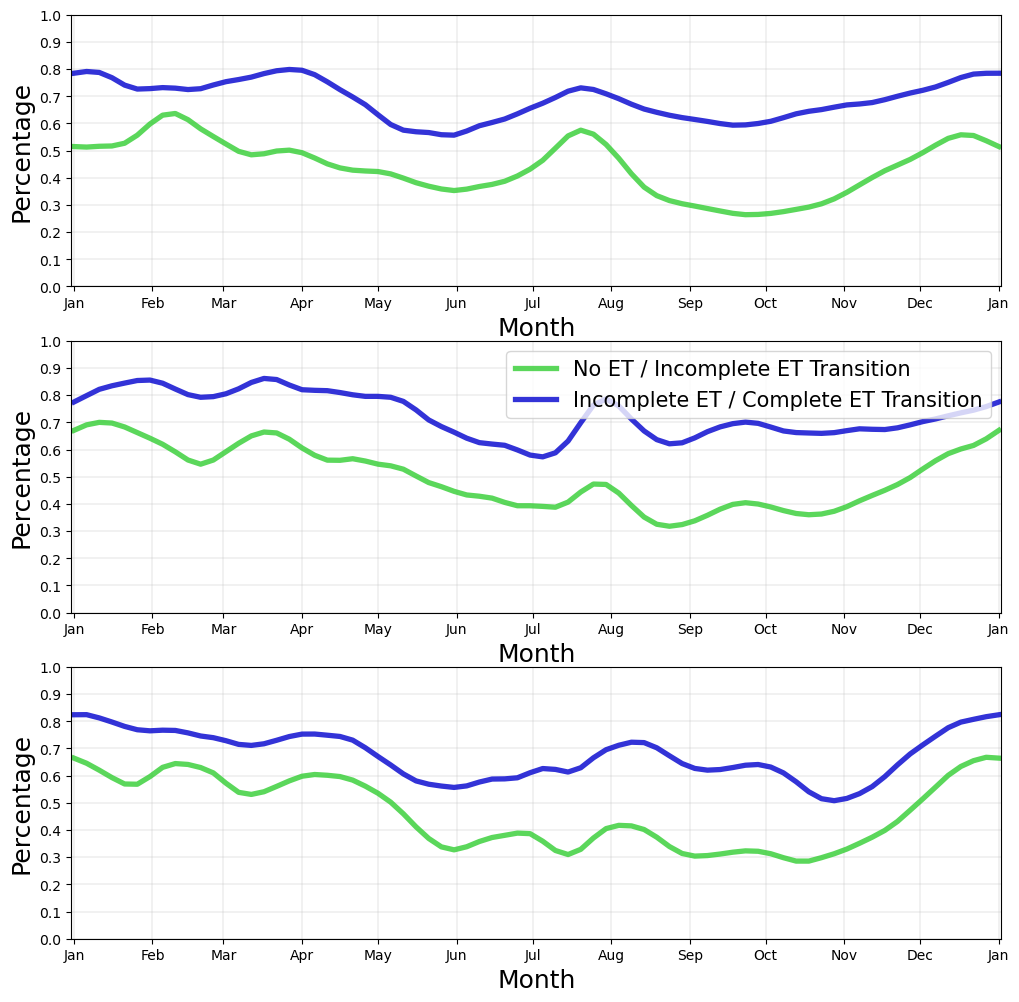

In [54]:
Fig = pyplot.figure(figsize=(12,12))
ET_Status_Percent_Plot(Fig, Control_ET_Percent_Final, RCP45_ET_Percent_Final, \
RCP85_ET_Percent_Final, Day_Vals)

In [55]:
def Final_Percent_Formatting(Axis, Values, ET_Percent):
    Axis.plot(Values, ET_Percent[0], color='limegreen', linewidth=3.8, \
    label='Control', alpha=0.8)
    Axis.plot(Values, ET_Percent[1], color='orange', linewidth=3.8, \
    label='RCP4.5', alpha=0.8)
    Axis.plot(Values, ET_Percent[2], color='red', linewidth=3.8, \
    label='RCP8.5', alpha=0.8)
    pyplot.xticks(Month_Days, Months)
    pyplot.xlim(-1,366)
    pyplot.yticks(Create_Bins(0,1,0.1))
    pyplot.ylim(0,1)
    pyplot.xlabel("Month", fontsize=18)
    pyplot.ylabel("Percentage", fontsize=18)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [56]:
# Create Function to Plot Final Product
def Final_Percent_Plot(Fig, Control, RCP45, RCP85, Values):
    No_ET = numpy.zeros((3,len(Control[0])))
    Incomp_ET = numpy.zeros((3,len(Control[1])))
    Comp_ET = numpy.zeros((3,len(Control[2])))
    No_ET[0] = Control[0]
    Incomp_ET[0] = Control[1]
    Comp_ET[0] = Control[2]
    No_ET[1] = RCP45[0]
    Incomp_ET[1] = RCP45[1]
    Comp_ET[1] = RCP45[2]
    No_ET[2] = RCP85[0]
    Incomp_ET[2] = RCP85[1]
    Comp_ET[2] = RCP85[2]
#
    Axis = Fig.add_subplot(3,1,1)
    Final_Percent_Formatting(Axis, Values, No_ET)
    Title = "Seasonal Probability of No ET Transition"
    pyplot.title(Title, fontsize=25)
#
    Axis = Fig.add_subplot(3,1,2)
    Final_Percent_Formatting(Axis, Values, Incomp_ET)
    Title = "Seasonal Probability of Incomplete ET Transition"
    pyplot.title(Title, fontsize=25)
    pyplot.legend(loc=1, fontsize=15)
#
    Axis = Fig.add_subplot(3,1,3)
    Final_Percent_Formatting(Axis, Values, Comp_ET)
    Title = "Seasonal Probability of Complete ET Transition"
    pyplot.title(Title, fontsize=25)

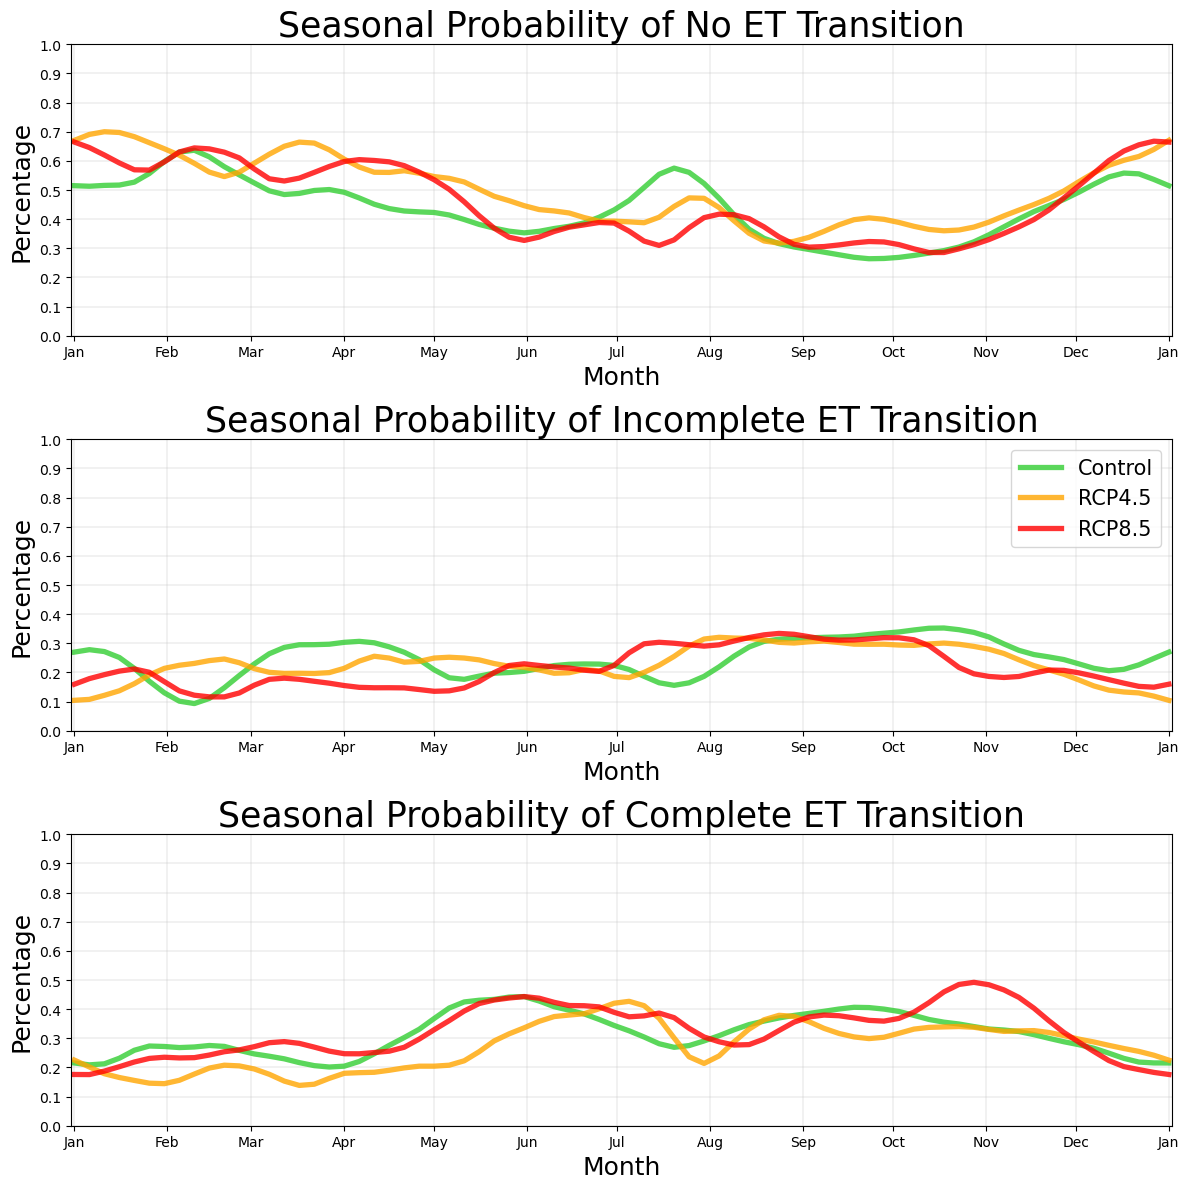

In [57]:
Fig = pyplot.figure(figsize=(12,12))
Final_Percent_Plot(Fig, Control_ET_Percent_Final, RCP45_ET_Percent_Final, RCP85_ET_Percent_Final, Day_Vals)
Figname = str('Seasonal_ET_Completion_Percent.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V4/'+Figname, bbox_inches='tight')
pyplot.tight_layout()

In [58]:
# Create Function to Plot Final Product
def Complete_ET_Percent_Plot(Fig, Control, RCP45, RCP85, Values):
    Comp_ET = numpy.zeros((3,len(Control[2])))
    Comp_ET[0] = Control[2]
    Comp_ET[1] = RCP45[2]
    Comp_ET[2] = RCP85[2]
#
    Axis = Fig.add_subplot(1,1,1)
    Final_Percent_Formatting(Axis, Values, Comp_ET)
    Title = "Seasonal Probability of Complete ET Transition"
    pyplot.title(Title, fontsize=25)
    pyplot.legend(loc=1, fontsize=15)

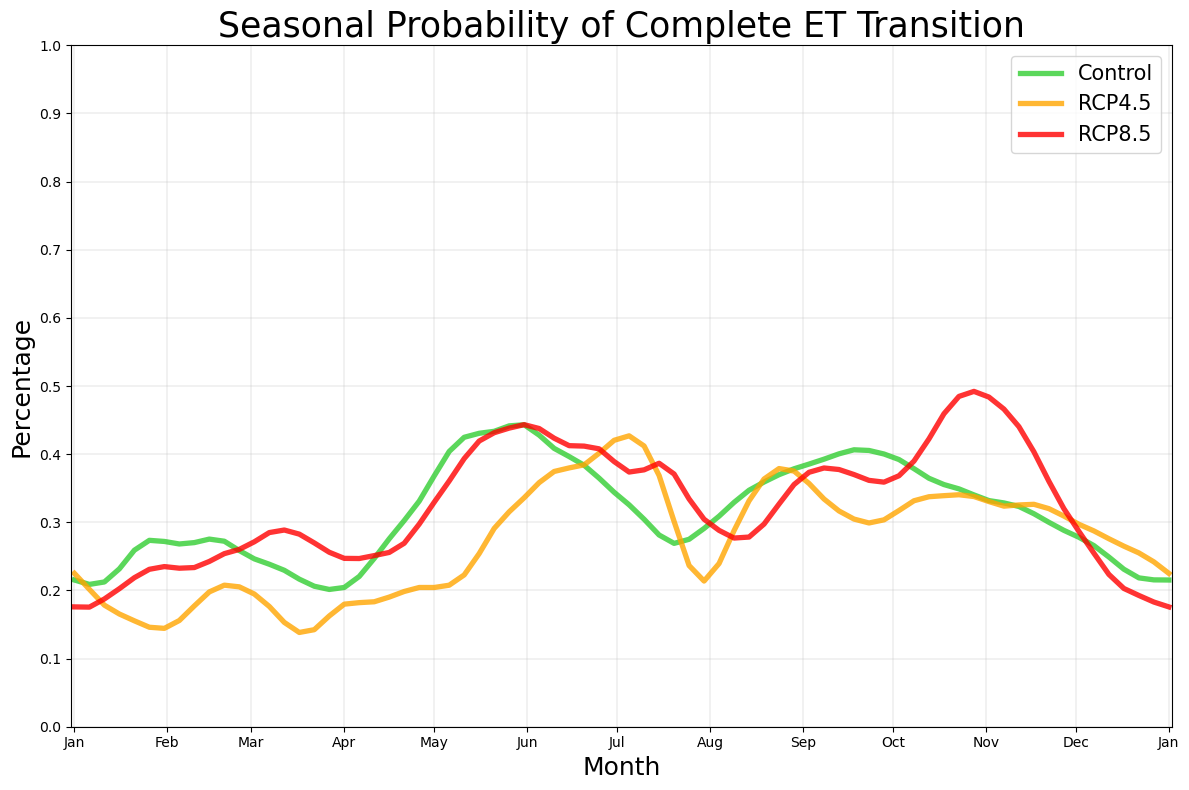

In [59]:
Fig = pyplot.figure(figsize=(12,8))
Complete_ET_Percent_Plot(Fig, Control_ET_Percent_Final, RCP45_ET_Percent_Final, RCP85_ET_Percent_Final, Day_Vals)
Figname = str('Seasonal_Complete_ET_Prob.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V4/'+Figname, bbox_inches='tight')
pyplot.tight_layout()